## Skillbuilder: Initial Exploration
This file deals with the skillbuilder data and provides the basis and explanations of our data preprocessing so eg how we in the end imported the data (which columns, what was filtered,...) and why we did it that way.

In [24]:
import numpy as np
import pandas as pd
from torchbkt import *
from datahelper import *
from datahelper.constants import skillbuilder_n_skills, skillbuilder_max_skills
from scipy.special import comb
from collections import Counter

## Import Skillbuilder-Data
Only rows where skill id is not "NA" are imported and used

In [25]:
path = "data/skill_builder_data_corrected_collapsed.csv"

usable_col = ["order_id", "user_id", "correct", "skill_id","problem_id"]
df = pd.read_csv(path, usecols = usable_col, dtype={"skill_id": str} )
df = df[df.skill_id.notnull()]
df = df.sort_values(by=["order_id"])
skill_cols = ['skill_name' + str(i) for i in range(4)]
df[skill_cols] = df['skill_id'].str.split('_', 0, expand=True)

importer = SkillbuilderImporter()
skillbuilder = importer(path, ["problem_id"])
skillbuilder.head(5)

,order_id,user_id,problem_id,correct,skill_id,skill_name0,skill_name1,skill_name2,skill_name3
222489,20224085,73963,76429,0,297,297,None,None,None
222490,20224095,73963,76430,1,297,297,None,None,None
222491,20224113,73963,76431,1,297,297,None,None,None
222492,20224123,73963,76432,1,297,297,None,None,None
222493,20224142,73963,76433,0,297,297,None,None,None


## General Information about Data columns
Not all information will be used in our project, everything in **bold** is relevant and in some way used
- **order_id: These id's are chronological, and refer to the id of the original problem log.**
- assignment_id: Two different assignments can have the same sequence id. Each assignment is specific to a single teacher/class.
- **user_id: The ID of the student doing the problem.**
- assistment_id: The ID of the ASSISTment. An ASSISTment consists of one or more problems.
- **problem_id: The ID of the problem.**
- original:
    - 1 = Main problem
    - 0 = Scaffolding problem
- **correct**
    - 1 = Correct on the first attempt
    - 0 = Incorrect on the first attempt, or asked for help.
    - This column is often the target for prediction
- attempt_count: Number of student attempts on this problem.
- ms_first_response: The time in milliseconds for the student's first response.
- tutor_mode: tutor, test mode, pretest, or posttest
- answer_type: 
    - choose_1: Multiple choice (radio buttons)
    - algebra: Math evaluated string (text box)
    - fill_in: Simple string-compared answer (text box)
    - open_response: Records student answer, but their response is always marked correct

- sequence_id: The content id of the problem set. Different assignments that assign the same problem set will have the same sequence id.
- student_class_id: The class ID.
- position: Assignment position on the class assignments page.
- type:
    - Linear - Student completes all problems in a predetermined order.
    - Random - Student completes all problems, but each student is presented with the problems in a different random order.
    - Mastery - Random order; and students must "master" the problem set by getting a certain number of questions (3 by default) correct in a row before being able to continue.
- base_sequence_id: This is to account for if a sequence has been copied. This will point to the original copy, or be the same as sequence_id if it hasn't been copied.
- **skill_id: ID of the skill associated with the problem. Different skills for the same data record are in the same row, separated with underscore.**
- skill_name: Skill name associated with the problem. -> still to find out what happens if multiple skills

- teacher_id: The ID of the teacher who assigned the problem.

- school_id: The ID of the school where the problem was assigned.

- hint_count: Number of student attempts on this problem.

- hint_total: Number of possible hints on this problem.

- overlap_time: The time in milliseconds for the student's overlap time.

- template_id: The template ID of the ASSISTment. ASSISTments with the same template ID have similar questions.

- answer_id: The answer ID for multi-choice questions.

- answer_text: The answer text for fill-in questions.

- first_action: The type of first action: attemp or ask for a hint.

- bottom_hint: Whether or not the student asks for all hints.

- opportunity: The number of opportunities the student has to practice on this skill. For the non skill builder dataset, opportunities for different skills of the same data record are in the same row, separated with comma.

- opportunity_original: The number of opportunities the student has to practice on this skill counting only original problems. For the non skill builder dataset, original opportunities for different skills of the same data record are in the same row, separated with comma.

## General Analysis

In [26]:
uniques = np.unique(skillbuilder["skill_id"].astype(str))
l = [set(x.split("_")) for x in uniques]
flat_list = set(item for sublist in l for item in sublist)
stud = np.unique(skillbuilder["user_id"])
num_stud = len(stud)
num_entries = len(skillbuilder)

print("Imported data entries:",num_entries)
print("Number of students:",num_stud)
print("Number of different exercise types:", len(uniques))
print("Number of different exercises:",len(np.unique(skillbuilder["problem_id"])))
print("Number of different skills:",len(flat_list))

#Students
print("Average exercises per student:",num_entries/num_stud)


d = []
for s in stud:
    count = len(skillbuilder.loc[skillbuilder['user_id'] == s])
    d.append(
        {
            'Student': s,
            "Number Exercises": count,
        }
    )

df_stud = pd.DataFrame(d)
print("Students that filled most exercises")
print(df_stud.sort_values(by=["Number Exercises"],ascending=False).head(10))


print("Number of students that filled more than 100 exercises:",len(df_stud[df_stud["Number Exercises"]>=100]))

#Skills
counter_dict = Counter(skillbuilder["skill_id"])
counter_dict


Imported data entries: 346860
Number of students: 4217
Number of different exercise types: 150
Number of different exercises: 26688
Number of different skills: 124
Average exercises per student: 82.25278634100071
Students that filled most exercises
      Student  Number Exercises
708     78978              1383
700     78970              1334
760     79032              1264
751     79021              1239
4191    96274              1236
709     78979              1163
4161    96244              1149
162     75169              1129
743     79013              1124
719     78989              1115
Number of students that filled more than 100 exercises: 836


Counter({'297': 2978,
         '294': 1760,
         '17': 3890,
         '10_13': 1551,
         nan: 63755,
         '9_14': 956,
         '10_12': 963,
         '9_12': 1244,
         '10_15': 934,
         '10_14': 970,
         '11': 3864,
         '9_15': 1059,
         '4': 1804,
         '2_48_79': 946,
         '10_64': 607,
         '10_18': 881,
         '8': 1859,
         '278': 4320,
         '67': 5547,
         '277': 12741,
         '279': 7058,
         '58_85': 2059,
         '58': 1816,
         '280': 11334,
         '85': 2900,
         '74_85': 2168,
         '311': 24253,
         '309': 3072,
         '46': 4434,
         '16_17': 4073,
         '50': 6117,
         '40': 1769,
         '10_104': 99,
         '1_15': 1312,
         '1_13': 2212,
         '76': 3050,
         '51': 2007,
         '47': 18739,
         '11_70': 1945,
         '81': 3183,
         '49': 4895,
         '2_70': 1807,
         '54': 951,
         '307': 926,
         '310': 4659,
   

## Filter data
It is not usefull to look at skills, where we have a really small amount of exercises. By visual inspection of counter_dict, all skills, that do have less than __30 exercises__ (we include skill a if it has enough exercises combining all exercise types in which it occurs, so single exercise types can have less than 30 exercises). We checked before removing, that this does not change or falsify the data that remains (removed demarcated exercises, checked in other cases if removing influences sequences)

In [27]:
too_less_exercises = ["5_102","348","334","331","340","43"]
filtered_skillb = skillbuilder[~skillbuilder["skill_id"].isin(too_less_exercises)]
filtered_skillb.head(5)

# Change 27_321 to 27 as there are no other exercises 321
filtered_skillb = filtered_skillb.replace("27_321","27")

uniques = np.unique(filtered_skillb["skill_id"].astype(str))
l = [set(x.split("_")) for x in uniques]

## Block analysis
Analysis if different skills occur in blocks (important for fitting, as using all skills at once would be to difficult concerning correlations in fitting)

In [28]:
stop = True
while stop:
    for i in range(len(l)-1):
        for j in range(i+1,len(l)):
            if len(l[i].intersection(l[j]))>0:
                l[i] = l[i].union(l[j])
                l.pop(j)
                break
    if i==len(l)-2:
        stop=False

        
print("Number of blocks:",len(l),", Maximum length of a block",max(len(y) for y in [list(x) for x in l]))
print("Blocks of skills present in the data:",l)

Number of blocks: 76 , Maximum length of a block 15
Blocks of skills present in the data: [{'323', '10', '14', '9', '64', '1', '104', '74', '13', '85', '18', '58', '12', '15', '92'}, {'101'}, {'105', '99', '97'}, {'48', '37', '77', '35', '51', '24', '75', '47', '2', '79', '63', '11', '46', '53', '70'}, {'110'}, {'17', '16'}, {'163'}, {'165'}, {'166'}, {'221', '173', '190', '193'}, {'203'}, {'204'}, {'22', '21'}, {'217'}, {'25'}, {'26'}, {'27'}, {'276'}, {'277'}, {'81', '69', '278', '34'}, {'279'}, {'280'}, {'290'}, {'292', '293'}, {'294'}, {'295'}, {'296'}, {'297'}, {'298'}, {'299'}, {'301'}, {'303'}, {'307'}, {'308'}, {'309'}, {'310'}, {'311'}, {'312'}, {'314'}, {'317'}, {'32'}, {'322'}, {'324'}, {'325'}, {'333'}, {'343'}, {'346'}, {'350'}, {'356'}, {'362'}, {'365'}, {'367'}, {'368'}, {'371'}, {'378'}, {'39'}, {'4'}, {'40'}, {'42'}, {'50', '49'}, {'54'}, {'375', '5'}, {'61'}, {'65'}, {'67'}, {'76'}, {'8'}, {'80'}, {'82'}, {'83'}, {'84'}, {'86'}, {'91'}, {'94'}, {'96'}, {'nan'}]


## Cutting blocks to a max size of 5
We have two blocks of size 15 -> this is to big for our model, therefore we try to filter the data accordingly, such that we have blocks of at most size 5. This is tricky as there are multiple dependencies eg if I want to learn skill 13 and look at one student, I need to include all exercises that include skill 13 that this student solved to not get wrong results

In [29]:
# Try removing ex 10, skill 10 lost
filtered_skillb_wo10 = filtered_skillb.replace("10_12","12")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("10_13","13")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("10_15","15")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("10_18","18")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("10_64","64")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("10_14","14")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("10_58","58")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("10_104","104")
#remove 9, skill 9 lost
filtered_skillb_wo10 = filtered_skillb_wo10.replace("9_12","12")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("9_14","14")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("9_13","13")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("9_15","15")
#split 63,75,51,53 (25 ex cut)
filtered_skillb_wo10 = filtered_skillb_wo10.replace("63_75","75")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("48_63_70_79","48_70")
filtered_skillb_wo10 = filtered_skillb_wo10.replace("48_63_79","48")

#split 46,79, 25 ex cut
filtered_skillb_wo10 = filtered_skillb_wo10.replace("46_79","46")
#split 47, 3 ex cut
filtered_skillb_wo10 = filtered_skillb_wo10.replace("47_63_70_77","70_77")
#split 79
filtered_skillb_wo10 = filtered_skillb_wo10.replace("2_48_79","2_48")





uniques = np.unique(filtered_skillb_wo10["skill_id"].astype(str))
l = [set(x.split("_")) for x in uniques]

## Use graph theory for last cuts
Cut such that the block divides itsself into 2 by cuting the minimum edge weight

In [30]:
from networkx.algorithms.connectivity.cuts import minimum_edge_cut
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

#G.add_edge(11, 70, weight=1945)
#G.add_edge(79, 70, weight=5)
#G.add_edge(79, 2, weight=946)
#G.add_edge(79, 48, weight=961)
G.add_edge(37, 70, weight=1474+1588+399)
G.add_edge(77, 70, weight=3)
G.add_edge(48, 70, weight=1582+399+5)
G.add_edge(2, 70, weight=1807+1474)
G.add_edge(37, 77, weight=1582)
G.add_edge(37, 48, weight=1582+377)
G.add_edge(37, 2, weight=1474+1582+399)
G.add_edge(77, 48, weight=1582)
G.add_edge(2, 48, weight=946+1582)

{(37, 77), (48, 77), (70, 77)}

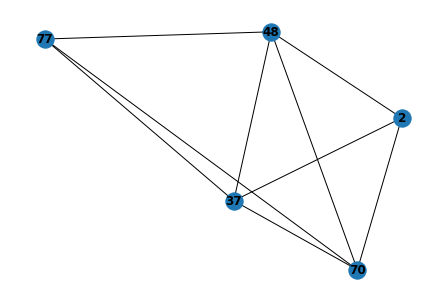

In [31]:
nx.draw(G, with_labels=True, font_weight='bold')
minimum_edge_cut(G)

In [32]:
stop = True
while stop:
    for i in range(len(l)-1):
        for j in range(i+1,len(l)):
            if len(l[i].intersection(l[j]))>0:
                l[i] = l[i].union(l[j])
                l.pop(j)
                break
    if i==len(l)-2:
        stop=False

        
print("Number of blocks:",len(l),", Maximum length of a block",max(len(y) for y in [list(x) for x in l]))
print("Blocks of skills present in the data:",l)

Number of blocks: 87 , Maximum length of a block 6
Blocks of skills present in the data: [{'1', '15', '13'}, {'101'}, {'104'}, {'105', '99', '97'}, {'48', '2', '37', '11', '70', '77'}, {'110'}, {'12'}, {'14'}, {'17', '16'}, {'163'}, {'165'}, {'166'}, {'221', '173', '190', '193'}, {'18'}, {'203'}, {'204'}, {'22', '21'}, {'217'}, {'46', '24', '35'}, {'25'}, {'26'}, {'27'}, {'276'}, {'277'}, {'81', '69', '278', '34'}, {'279'}, {'280'}, {'290'}, {'292', '293'}, {'294'}, {'295'}, {'296'}, {'297'}, {'298'}, {'299'}, {'301'}, {'303'}, {'307'}, {'308'}, {'309'}, {'310'}, {'311'}, {'312'}, {'314'}, {'317'}, {'32'}, {'322'}, {'323', '58', '74', '85', '92'}, {'324'}, {'325'}, {'333'}, {'343'}, {'346'}, {'350'}, {'356'}, {'362'}, {'365'}, {'367'}, {'368'}, {'371'}, {'378'}, {'39'}, {'4'}, {'40'}, {'42'}, {'47'}, {'50', '49'}, {'53', '51', '75'}, {'54'}, {'375', '5'}, {'61'}, {'63'}, {'64'}, {'65'}, {'67'}, {'76'}, {'79'}, {'8'}, {'80'}, {'82'}, {'83'}, {'84'}, {'86'}, {'91'}, {'94'}, {'96'}, {'nan